<a href="https://colab.research.google.com/github/nva1dman/Echelle-Spectrum-Processing/blob/main/code_for_orbital_period.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import emcee
import corner

In [ ]:
# Чтение данных
data = pd.read_csv('hd_results.dat', delim_whitespace=True, header=None, names=["JD", "RV", "Error"])

In [ ]:
# Начальное приближение периода (я беру его с сайта NASA)
# https://exoplanetarchive.ipac.caltech.edu/cgi-bin/Pgram/nph-pgram
initial_period = 55.9489676

**Логарифмическая функция правдоподобия:**

Оценивается правдоподобие модели, сравнивая наблюдаемые данные $ \text{RV}_{\text{obs}} $ с модельными данными $ \text{RV}_{\text{model}} $:

$$
\ln \mathcal{L}(\theta) = -\frac{1}{2} \sum \left( \frac{(\text{RV}_{\text{obs}} - \text{RV}_{\text{model}})^2}{\sigma^2} + \ln \sigma^2 \right)
$$

где $ \theta = [\gamma, K, \omega, e] $ — параметры модели, $ \sigma $ — ошибки измерений.

**Сканирование по периоду:**

Исследуется логарифм правдоподобия для различных значений периода $ P $ в заданном диапазоне. Оптимальный период соответствует максимуму логарифма правдоподобия.

**Уточнение периода:**

После нахождения оптимального периода выполняется более точное сканирование в узком диапазоне вокруг найденного значения. Для определения доверительного интервала вычисляются точки, где логарифм правдоподобия на 0.5 меньше максимального значения:

$$
\text{fine\_error\_period} = \left( P_{\text{right}} - P_{\text{best}}, P_{\text{best}} - P_{\text{left}} \right)
$$

В данной среде код будет считать достаточно долго, так как стоит две выборка по 5000 значений.

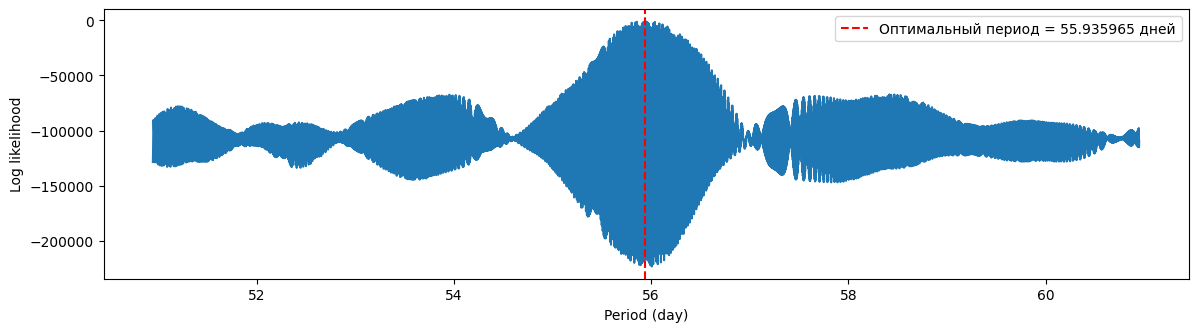

Найденный оптимальный период: 55.935965 дней
Доверительный интервал: ±0.001300/0.005061 дней


In [ ]:
# Функция расчета фазы
def calculate_phase(jd, period):
    return np.mod(jd, period) / period

# Функция для удаления выбросов
def remove_outliers(x, y, yerr, threshold=3):
    mean_y = np.mean(y)
    std_y = np.std(y)
    mask = np.abs(y - mean_y) < threshold * std_y
    return x[mask], y[mask], yerr[mask]

# Модель эллиптической орбиты с периодом
def elliptical_rv_model(phase, gamma, K, omega, e, period):
    phase_mod = calculate_phase(phase * period, period)
    return gamma + K * np.cos(2 * np.pi * phase_mod + omega) / (1 + e * np.cos(2 * np.pi * phase_mod))

# Логарифмическая функция правдоподобия
def log_likelihood(theta, period, jd, rv, rv_err):
    gamma, K, omega, e = theta
    phase = calculate_phase(jd, period)
    model = elliptical_rv_model(phase, gamma, K, omega, e, period)
    sigma2 = rv_err**2
    return -0.5 * np.sum((rv - model)**2 / sigma2 + np.log(sigma2))

# Задаем диапазон значений периода для сканирования
period_range = np.linspace(initial_period - 5, initial_period + 5, 5000)

# Начальные значения параметров, кроме периода
initial_guess_elliptical = [np.mean(data['RV']), np.abs((np.max(data['RV']) - np.min(data['RV'])) / 2), np.pi, 0.036]

# Удаление выбросов
phase = calculate_phase(data['JD'], initial_period)
sorted_indices = np.argsort(phase)
sorted_phase = phase[sorted_indices]
sorted_rv = data['RV'][sorted_indices]
sorted_error = data['Error'][sorted_indices]
sorted_phase, sorted_rv, sorted_error = remove_outliers(sorted_phase, sorted_rv, sorted_error)

# Подсчет логарифма правдоподобия для каждого периода
likelihoods = []
for period in period_range:
    likelihood = log_likelihood(initial_guess_elliptical, period, data['JD'], sorted_rv, sorted_error)
    likelihoods.append(likelihood)

# Поиск периода с максимальной правдоподобностью
best_period = period_range[np.argmax(likelihoods)]

# Построение графика логарифма правдоподобия в зависимости от периода
plt.figure(figsize=(14, 3.5))
plt.plot(period_range, likelihoods)
plt.xlabel('Period (day)')
plt.ylabel('Log likelihood')
plt.axvline(best_period, color='red', linestyle='--', label=f'Оптимальный период = {best_period:.6f} дней')
plt.legend()
plt.show()

# Обновление начального приближения периода для дальнейшего использования в MCMC
initial_period = best_period

# Более точное сканирование периода в узком диапазоне вокруг найденного значения
fine_period_range = np.linspace(best_period - 0.1, best_period + 0.1, 5000)

# Повторный подсчет логарифма правдоподобия для более точного диапазона
fine_likelihoods = []
for period in fine_period_range:
    likelihood = log_likelihood(initial_guess_elliptical, period, data['JD'], sorted_rv, sorted_error)
    fine_likelihoods.append(likelihood)

# Найти новый максимум и границы
fine_max_likelihood = np.max(fine_likelihoods)

# Ищем границы, где логарифм правдоподобия на sigma_1 меньше максимума
sigma_1 = 0.5
fine_left_idx = np.where(fine_likelihoods > (fine_max_likelihood - sigma_1))[0][0]
fine_right_idx = np.where(fine_likelihoods > (fine_max_likelihood - sigma_1))[0][-1]

# Соответствующие периоды
fine_left_period = fine_period_range[fine_left_idx]
fine_right_period = fine_period_range[fine_right_idx]

# Ошибка периода
fine_error_period = (fine_right_period - best_period, best_period - fine_left_period)

print(f"Найденный оптимальный период: {best_period:.6f} дней")
print(f"Доверительный интервал: ±{fine_error_period[0]:.6f}/{fine_error_period[1]:.6f} дней")

С периодом определились. Двигаемся дальше!

  0%|          | 0/1500 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1500/1500 [01:15<00:00, 19.80it/s]


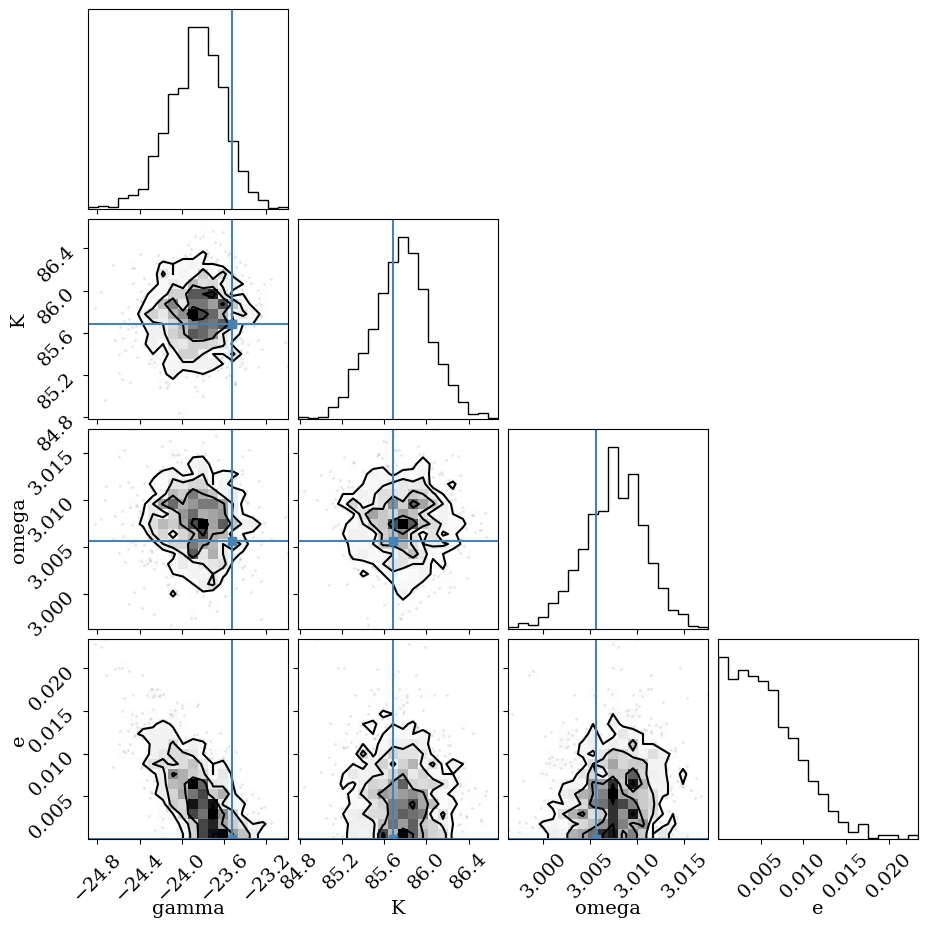

In [ ]:
# Расчет фазы
phase = np.mod(data['JD'], best_period) / best_period
sorted_indices = np.argsort(phase)
sorted_phase = phase[sorted_indices]
sorted_rv = data['RV'][sorted_indices]
sorted_error = data['Error'][sorted_indices]

# Функция для удаления выбросов
def remove_outliers(x, y, yerr, threshold=3):
    mean_y = np.mean(y)
    std_y = np.std(y)
    mask = np.abs(y - mean_y) < threshold * std_y
    return x[mask], y[mask], yerr[mask]

sorted_phase, sorted_rv, sorted_error = remove_outliers(sorted_phase, sorted_rv, sorted_error)

# Модель эллиптической орбиты
def elliptical_rv_model(phase, gamma, K, omega, e):
    return gamma + K * np.cos(2 * np.pi * phase + omega) / (1 + e * np.cos(2 * np.pi * phase))

# Начальные приближения для параметров
initial_guess_elliptical = [np.mean(sorted_rv), np.abs((np.max(sorted_rv) - np.min(sorted_rv)) / 2), np.pi, 0.036]

# Ограничения для параметров
bounds = ([-np.inf, 0, 0, 0], [np.inf, np.inf, 2 * np.pi, 1])

# Подгонка модели с учетом начальных условий и ограничений
params_no_sigma_elliptical, params_cov_no_sigma_elliptical = curve_fit(elliptical_rv_model, sorted_phase, sorted_rv, p0=initial_guess_elliptical, bounds=bounds)
fitted_gamma, fitted_K, fitted_omega, fitted_e = params_no_sigma_elliptical

# Логарифмическая функция правдоподобия
def log_likelihood(theta, phase, rv, rv_err):
    gamma, K, omega, e = theta
    model = elliptical_rv_model(phase, gamma, K, omega, e)
    sigma2 = rv_err**2
    return -0.5 * np.sum((rv - model)**2 / sigma2 + np.log(sigma2))

# Функция приоритета
def log_prior(theta):
    gamma, K, omega, e = theta
    if 0 < K < 100 and 0 < omega < 2 * np.pi and 0 < e < 1:
        return 0.0
    return -np.inf

# Логарифм полной вероятности
def log_probability(theta, phase, rv, rv_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, phase, rv, rv_err)

# Начальная позиция и параметры для MCMC
pos = params_no_sigma_elliptical + 1e-4 * np.random.randn(32, 4)
nwalkers, ndim = pos.shape

# Запуск MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(sorted_phase, sorted_rv, sorted_error))
sampler.run_mcmc(pos, 1500, progress=True)

# Получение выборки и построение углового графика
samples = sampler.get_chain(discard=1000, thin=15, flat=True)
labels = ["gamma", "K", "omega", "e"]
fig = corner.corner(samples, labels=labels, truths=params_no_sigma_elliptical)
plt.show()

# Вычисление средних и доверительных интервалов для параметров
gamma_mcmc, K_mcmc, omega_mcmc, e_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))

omega_mcmc_deg = omega_mcmc[0] * (180 / np.pi)
omega_error_deg = (omega_mcmc[1] * (180 / np.pi), omega_mcmc[2] * (180 / np.pi))

# Постоянные
G = 6.67430e-11
day_to_sec = 86400
AU_to_m = 1.496e+11

updated_period_sec = period * day_to_sec

# Функция массы
f_m_updated = (np.abs(K_mcmc[0]) * 1e3)**3 * updated_period_sec / (2 * np.pi * G * (1 - e_mcmc[0]**2)**(3/2))
f_m_solar_updated = np.abs(f_m_updated / 1.989e+30)

omega_error_days_updated = omega_error_deg[0] / 360 * period
error_f_m = f_m_solar_updated * np.sqrt((3 * K_mcmc[1] / np.abs(K_mcmc[0]))**2 + (3 * omega_error_days_updated / period)**2)

phase_at_t0_updated = (np.pi/2 - omega_mcmc[0]) / (2 * np.pi) % 1
additional_crossing_updated = (3 * np.pi/2 - omega_mcmc[0]) / (2 * np.pi) % 1

if abs(phase_at_t0_updated - 0.5) < abs(additional_crossing_updated - 0.5):
    phase_at_t0_updated = phase_at_t0_updated
else:
    phase_at_t0_updated = additional_crossing_updated

hjd_at_t0_updated = data['JD'].min() + phase_at_t0_updated * period

t0_error_updated = omega_error_days_updated

In [ ]:
# Вывод результатов с учетом ошибок MCMC
updated_results_with_mcmc_errors = {
    'Gamma (системная скорость)': f"{gamma_mcmc[0]:.3f} ± {gamma_mcmc[1]:.3f}/{gamma_mcmc[2]:.3f}",
    'K (полуамплитуда)': f"{np.abs(K_mcmc[0]):.3f} ± {K_mcmc[1]:.3f}/{K_mcmc[2]:.3f}",
    'Omega (градусы)': f"{omega_mcmc_deg:.3f} ± {omega_error_deg[0]:.3f}/{omega_error_deg[1]:.3f}",
    'e (эксцентриситет)': f"{e_mcmc[0]:.3f} ± {e_mcmc[1]:.3f}/{e_mcmc[2]:.3f}",
    'T0 (HJD)': f"{hjd_at_t0_updated:.3f} ± {t0_error_updated:.3f} дней",
    'Функция массы (f(m))': f"{f_m_solar_updated:.6f} ± {error_f_m:.3f} солнечных масс",
    'Период': f"{best_period:.3f} дней ± {fine_error_period[0]:.3f} / {fine_error_period[1]:.3f}"
}

for key, value in updated_results_with_mcmc_errors.items():
    print(f"{key}: {value}")

Gamma (системная скорость): -23.849 ± 0.237/0.268
K (полуамплитуда): 85.772 ± 0.244/0.277
Omega (градусы): 172.323 ± 0.172/0.190
e (эксцентриситет): 0.005 ± 0.005/0.004
T0 (HJD): 2456997.753 ± 0.027 дней
Функция массы (f(m)): 3.662838 ± 0.032 солнечных масс
Период: 55.936 дней ± 0.001 / 0.005


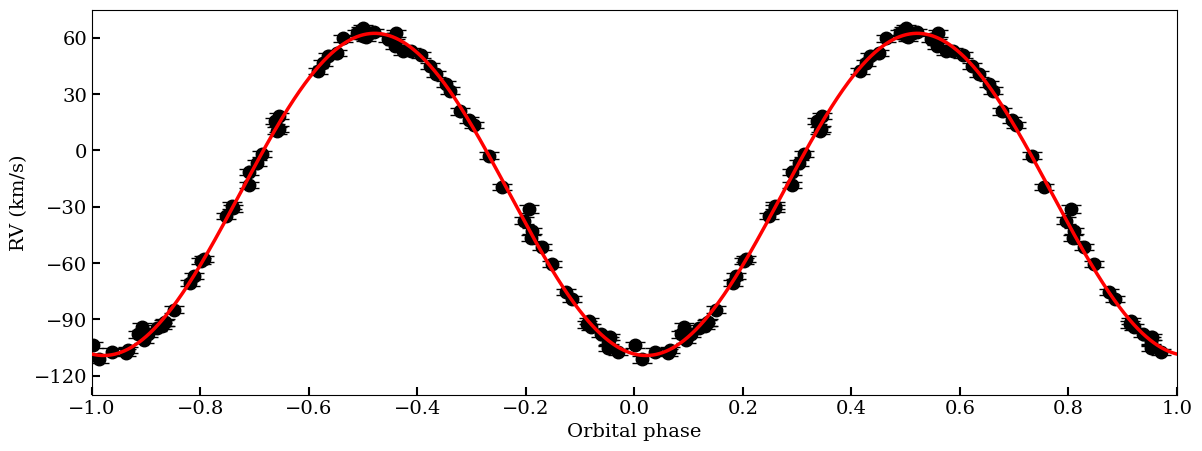

In [ ]:
# Построение графика
phase_fine = np.linspace(0, 1, 1000)
rv_fitted = elliptical_rv_model(phase_fine, gamma_mcmc[0], K_mcmc[0], omega_mcmc[0], e_mcmc[0])

plt.rc('font', family='serif', size=14)
plt.rc('axes', titlesize=14)  # Размер шрифта для заголовков осей
plt.rc('axes', labelsize=14)  # Размер шрифта для меток осей
plt.rc('xtick', labelsize=14)  # Размер шрифта для меток на оси X
plt.rc('ytick', labelsize=14)  # Размер шрифта для меток на оси Y

# Дублирование данных для фазы от -1 до 1
extended_phase = np.concatenate((sorted_phase - 1, sorted_phase))
extended_rv = np.concatenate((sorted_rv, sorted_rv))
extended_error = np.concatenate((sorted_error, sorted_error))

# Дублирование модели для фазы от -1 до 1
extended_phase_fine = np.concatenate((phase_fine - 1, phase_fine))
extended_rv_fitted = np.concatenate((rv_fitted, rv_fitted))

# Построение графика с фазой от -1 до 1
plt.figure(figsize=(14, 5))
plt.errorbar(extended_phase, extended_rv, yerr=extended_error, fmt='o', ecolor='black', color='black', capsize=7, markersize=9, label='Data')
plt.plot(extended_phase_fine, extended_rv_fitted, 'red', linewidth=2.5, label='Fitted Model', zorder=5)
plt.xlabel('Orbital phase')
plt.ylabel('RV (km/s)')

# Настройка промежуточных меток и шага по оси Y
plt.xticks(np.arange(-1, 1.1, 0.2))  # Шаг 0.2 по оси X
plt.yticks(np.arange(-120, 70, 30))  # Шаг 30 по оси Y

plt.xlim(-1, 1)
plt.ylim(-130, 75)

plt.tick_params(axis='both', which='both', direction='in', length=6, width=1.5)

plt.savefig('hd_698_new.pdf', bbox_inches='tight')

#plt.legend()
plt.show()